# IMAGE CLASSIFICATION USING TRANSFER LEARNING MODEL

In [12]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [14]:
data_dir = 'vehicle'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8)

In [15]:
train_data.class_to_idx

{'bike': 0, 'bus': 1, 'car': 2, 'truck': 3}

In [16]:
model = models.resnet18(pretrained=True)
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [17]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 4)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = fc

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
model.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 400)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(400, 4)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

In [20]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
epochs = 15
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/15.. Train loss: 2.464.. Test loss: 1.829.. Test accuracy: 0.250
Epoch 1/15.. Train loss: 1.570.. Test loss: 1.251.. Test accuracy: 0.588
Epoch 1/15.. Train loss: 1.613.. Test loss: 1.441.. Test accuracy: 0.487
Epoch 1/15.. Train loss: 1.540.. Test loss: 1.255.. Test accuracy: 0.588
Epoch 1/15.. Train loss: 1.310.. Test loss: 1.180.. Test accuracy: 0.487
Epoch 2/15.. Train loss: 1.274.. Test loss: 1.006.. Test accuracy: 0.525
Epoch 2/15.. Train loss: 1.256.. Test loss: 0.943.. Test accuracy: 0.500
Epoch 2/15.. Train loss: 1.062.. Test loss: 1.024.. Test accuracy: 0.600
Epoch 2/15.. Train loss: 1.225.. Test loss: 0.753.. Test accuracy: 0.850
Epoch 2/15.. Train loss: 1.125.. Test loss: 0.761.. Test accuracy: 0.838
Epoch 3/15.. Train loss: 1.058.. Test loss: 0.860.. Test accuracy: 0.600
Epoch 3/15.. Train loss: 1.127.. Test loss: 0.601.. Test accuracy: 0.863
Epoch 3/15.. Train loss: 1.117.. Test loss: 0.644.. Test accuracy: 0.762
Epoch 3/15.. Train loss: 0.982.. Test loss: 0.606..

In [23]:
torch.save(model.state_dict(), 'res18_10.pth')

In [24]:
def load_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(512, 400)),
                      ('relu', nn.ReLU()),
                      ('fc2', nn.Linear(400, 4)),
                      ('output', nn.LogSoftmax(dim=1))
                      ]))

    model.load_state_dict(ckpt, strict=False)

    return model

In [25]:
SAVE_PATH = 'res18_10.pth'

In [26]:
model = load_ckpt(SAVE_PATH)

In [27]:
import PIL
def process_image(image):
    im = PIL.Image.open(image)
    return test_transforms(im)

In [28]:
def predict(image_path, model):
    model.eval()
    img_pros = process_image(image_path)
    img_pros = img_pros.view(1,3,224,224)
    with torch.no_grad():
        output = model(img_pros)
    return output

In [29]:
def img_pred(impath):
  img_path = impath
  cls_score = int(torch.argmax(torch.exp(predict(img_path, model))))
  print("Predicted Output:",end=' ')
  if cls_score == 0:
      print('Bike')
  elif cls_score==1:
      print('Bus')
  elif cls_score==2:
      print('Car')
  else:
      print('Truck')
  print("Prediction Status :",torch.exp(predict(img_path, model)))

In [30]:
train_data.class_to_idx

{'bike': 0, 'bus': 1, 'car': 2, 'truck': 3}

# CLASSIFICATION OF SOME EXAMPLE IMAGES

Enter image path:vehicle/classification/10.png
Predicted Output: Car
Prediction Status : tensor([[4.1894e-04, 4.3636e-04, 9.9748e-01, 1.6654e-03]])


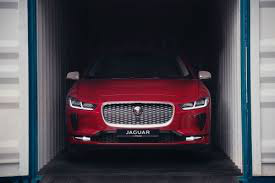

In [31]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:vehicle/classification/8.png
Predicted Output: Car
Prediction Status : tensor([[3.0535e-03, 3.9487e-04, 9.9512e-01, 1.4349e-03]])


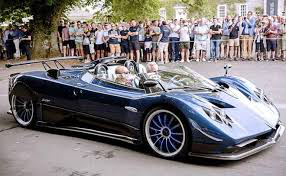

In [32]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:vehicle/classification/13.png
Predicted Output: Bus
Prediction Status : tensor([[0.0017, 0.9895, 0.0032, 0.0057]])


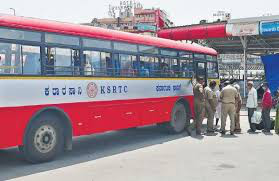

In [33]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:vehicle/classification/20.png
Predicted Output: Truck
Prediction Status : tensor([[0.0131, 0.1312, 0.0025, 0.8531]])


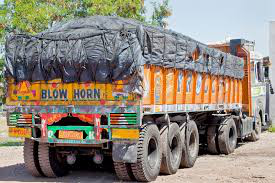

In [35]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:vehicle/classification/4.png
Predicted Output: Bike
Prediction Status : tensor([[0.9562, 0.0028, 0.0353, 0.0057]])


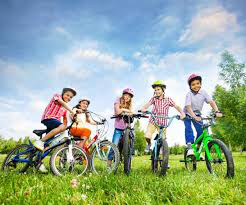

In [36]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)